In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from time import time

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from ensembles import RMSE, RandomForestMSE, GradientBoostingMSE

In [3]:
plt.rc('axes', axisbelow=True, grid=True)
plt.rc('grid', c='grey', ls=':')
plt.rc('image', cmap='Greys', interpolation='none')
plt.rc('font', family='serif', serif=['XCharter'])
plt.rc('mathtext', fontset='dejavuserif')
plt.rc('savefig', bbox='tight', pad_inches=0.1, format='pdf')

## Загрузка данных 

In [4]:
from sklearn.model_selection import train_test_split

dir0 = '../data/'
X = pd.read_csv(dir0 + 'train_data.csv', index_col=0)
y = pd.read_csv(dir0 + 'train_target.csv', index_col=0)
X['date'] = pd.to_datetime(X['date'])
print((X['date'].diff().astype('timedelta64[D]') < 0).any())
X

False


,id,date,bedrooms_number,batchrooms_number,square_footage_home,square_footage_lot,floors_number,has_waterfront,has_been_viewed,condition_quality,housing_unity_grade,square_footage_except_basement,square_footage_only_basement,build_year,renovation_year,coordinate_latitude,coordinate_longitude,square_footage_home_old,square_footage_lot_old
index,,,,,,,,,,,,,,,,,,,
0,16530,2014-05-02,2,2.00,1350,2560,1.0,0,0,3,8,1350,0,1976,0,200.6344,4.893,1790,2560
1,3651,2014-05-02,3,1.75,1800,23103,1.0,0,0,3,7,1800,0,1968,0,200.6517,5.094,1410,18163
2,13568,2014-05-02,3,1.75,2240,10578,2.0,0,0,5,8,1550,690,1923,0,200.6954,4.708,1570,10578
3,20352,2014-05-02,4,2.00,1820,5000,1.5,0,1,3,7,1640,180,1945,0,200.6815,4.731,2060,5000
4,10524,2014-05-02,4,1.75,1560,8700,1.0,0,0,4,7,1560,0,1967,0,200.7274,4.819,2080,8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,7718,2015-03-10,4,2.50,1921,4888,2.0,0,0,3,7,1921,0,2009,0,200.2689,4.760,1921,9140
17276,4556,2015-03-10,3,2.50,1890,11036,1.0,0,0,3,8,1460,430,1973,0,200.7426,4.646,2040,7524
17277,11634,2015-03-10,3,1.00,1380,10112,1.0,0,0,4,7,940,440,1963,0,200.3196,4.649,1240,10112


Хотя нам не предоставлено описание признаков, скорее всего столбец `date` связан со временем поступления данных (даты упорядочены и «находятся там, где следует находиться подобным отметкам»). Поэтому не будем шафлить датасет при разделении на обучение и валидацию. Из самих дат возьмем номер месяца, дня в месяце и день недели.

In [5]:
features = ['dayofweek', 'day', 'month']
for feature in features:
    X[feature] = getattr(X['date'].dt, feature)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X.drop(columns='date').to_numpy(), y.to_numpy().ravel(),
    shuffle=False, test_size=0.2)

In [8]:
%%time
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=20, n_jobs=-1)
model.fit(X_train, y_train)
RMSE(y_val, model.predict(X_val))

CPU times: user 18 s, sys: 58.3 ms, total: 18 s
Wall time: 2.48 s


130.85682292193016

In [18]:
RF_defaults_params = {
    'n_estimators': 100,
    'max_depth': 3,
}

RF_params = {
    'n_estimators': []
    'max_depth': 
    'random_state': 
}

fit_args = {
    'X': X_train,
    'y': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'return_train_loss': True,
    'return_val_loss': True,
}

train_loss, val_loss = model.fit(**fit_args)
# RMSE(y_val, model.predict(X_val))

1.07 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
model = RandomForestMSE(n_estimators=20)
model.fit(X_train, y_train)
RMSE(y_val, model.predict(X_val))

994 ms ± 45.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


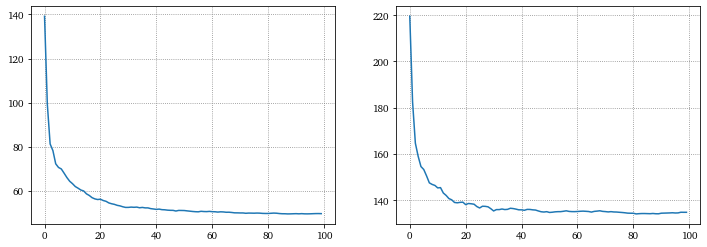

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(train_loss)
plt.subplot(122)
plt.plot(val_loss)